### Determine the optimal K number

* This notebook determines the optimal number of K-Prototype algorithm using Average silhouette method
* 514 features were selected out of the 1063 features. See the details in separate feature selection files.
* A subsample data set is used (1.25% of the original size data), missing values are imputed with mean.

Reference:  http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [44]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from kmodes.kprototypes import KPrototypes
%matplotlib inline

In [23]:
def process_data(file, categorical):
    '''
    Process the original data
    * Feature selection 514/1064
    * Impute missing values with means
    * return the new values, the index of categorical data, 
    and the policy number column
    '''
    df = pd.read_csv(file, low_memory=False)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    selected_variable = pd.read_csv('selectedVariables.csv')
    selected_variable.drop('Unnamed: 0', axis=1, inplace=True)
    df1 = df[df.columns.intersection(selected_variable.columns)]
    PolNum = np.asarray(df1.PolNum_UW)
    df2 = df1.iloc[:, :-1]
    
    # Separate numerical and categorical data
    # Select integers and turn to float
    df_num_int = df2.select_dtypes(include=['int64'])
    df_num_int = df_num_int.astype(float)
    # Select float
    df_num_float = df2.select_dtypes(include=['float64'])
    # Select categorical values
    df_cat = df2.select_dtypes(include=['object'])
    # Impute missing values with means

    df_num_int = df_num_int.fillna(df_num_int.mean())

    df_num_float = df_num_float.fillna(df_num_float.mean())
    print(df_num_int.shape, df_num_float.shape, df_cat.shape)
    X = pd.concat([df_num_int, df_num_float, df_cat], axis=1)
    X = X.values
    categorical = categorical
    return X, categorical, PolNum

def encode_features(X, enc_map=None):
    """Converts categorical values in each column of X to integers in the range
    [0, n_unique_values_in_column - 1], if X is not already of integer type.
    If mapping is not provided, it is calculated based on the values in X.
    Unknown values during prediction get a value of -1. np.NaNs are ignored
    during encoding, and get treated as unknowns during prediction.
    """
    if np.issubdtype(X.dtype, np.integer):
        # Already integer type, so we can take a shortcut. Simply reshape
        # the data to mapping dictionaries, and do nothing with X.
        enc_map = [{val: val for val in np.unique(col)} for col in X.T]
        return X, enc_map

    if enc_map is None:
        fit = True
        # We will calculate enc_map, so initialize the list of column mappings.
        enc_map = []
    else:
        fit = False

    Xenc = np.zeros(X.shape).astype('int')
    for ii in range(X.shape[1]):
        
        if fit:
            col_enc = {val: jj for jj, val in enumerate(np.unique(X[:, ii][~pd.isnull(X[:, ii])]))
                       if not (isinstance(val, float) and np.isnan(val))}
            enc_map.append(col_enc)
        # Unknown categories (including np.NaNs) all get a value of -1.
        Xenc[:, ii] = np.array([enc_map[ii].get(x, -1) for x in X[:, ii]])

    return Xenc, enc_map


##### subsample 1

In [24]:
X, categorical, PolNum = process_data('PHBsample14_sss.csv', range(498, 513))

(59159, 11) (59159, 487) (59159, 15)


In [25]:
Xenc, enc_map = encode_features(X, enc_map=None)

In [26]:
result_cost = []
result_score = []
result_iter = []
for k in range(3,14):
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=2)
    clusters = kproto.fit_predict(X, categorical=range(498, 513))
    result_cost.append(kproto.cost_)
    result_iter.append(kproto.n_iter_)
    score = silhouette_score(Xenc, kproto.labels_, sample_size=30000)
    result_score.append(score)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 15759, ncost: 3.074308690942619e+23
Run: 1, iteration: 2/100, moves: 2110, ncost: 3.039900649005691e+23
Run: 1, iteration: 3/100, moves: 762, ncost: 3.032079188193836e+23
Run: 1, iteration: 4/100, moves: 344, ncost: 3.02989545450529e+23
Run: 1, iteration: 5/100, moves: 10, ncost: 3.029893742479891e+23
Run: 1, iteration: 6/100, moves: 0, ncost: 3.029893742479891e+23
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 15404, ncost: 2.6435567968824245e+23
Run: 1, iteration: 2/100, moves: 840, ncost: 2.640471550030239e+23
Run: 1, iteration: 3/100, moves: 12, ncost: 2.6404692475683784e+23
Run: 1, iteration: 4/100, moves: 0, ncost: 2.6404692475683784e+23
Initialization me

In [28]:
k_range = range(3,14)

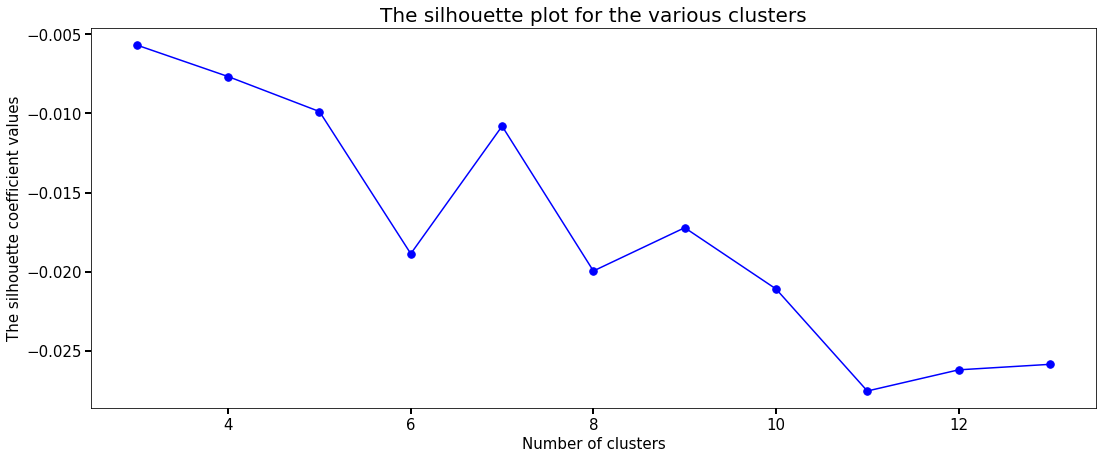

In [29]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 7)
ax.plot(k_range, result_score, marker='.', markersize=15, color='b')
ax.set_title("The silhouette plot for the various clusters", fontsize=20)
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("The silhouette coefficient values", fontsize=15)
ax.tick_params(direction='out', length=6, width=2, labelsize=15)
fig.savefig('OptimalK_silhouette_Kproto.png')

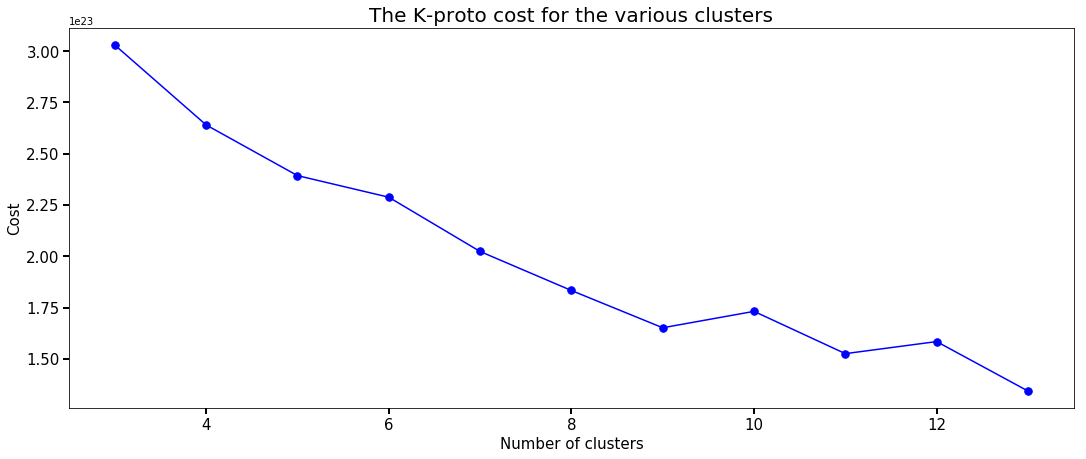

In [30]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 7)
ax.plot(k_range, result_cost, marker='.', markersize=15, color='b')
ax.set_title("The K-proto cost for the various clusters", fontsize=20)
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("Cost", fontsize=15)
ax.tick_params(direction='out', length=6, width=2, labelsize=15)

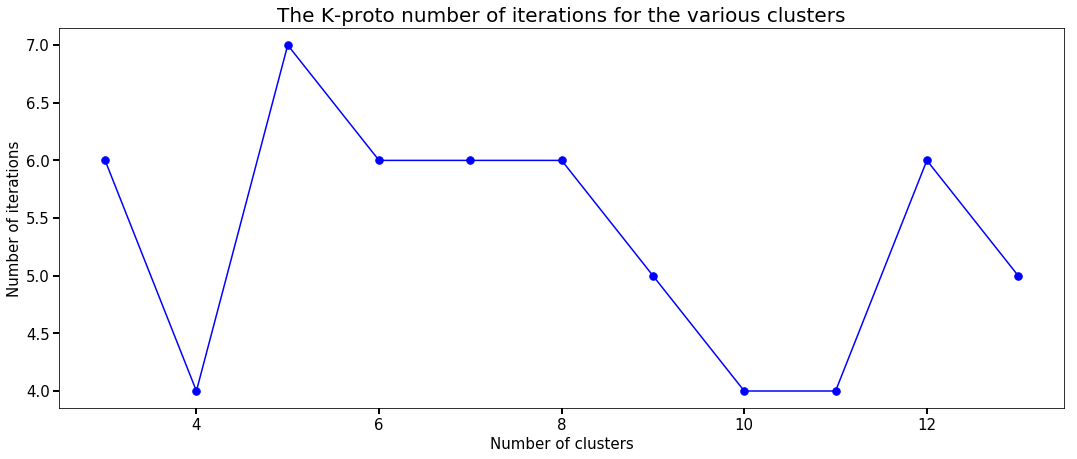

In [31]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 7)
ax.plot(k_range, result_iter, marker='.', markersize=15, color='b')
ax.set_title("The K-proto number of iterations for the various clusters", fontsize=20)
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("Number of iterations", fontsize=15)
ax.tick_params(direction='out', length=6, width=2, labelsize=15)

##### subsample 2

In [32]:
X, categorical, PolNum = process_data('PHBsample15_sss.csv', range(498, 513))

(59159, 11) (59159, 487) (59159, 15)


In [33]:
Xenc, enc_map = encode_features(X, enc_map=None)

In [34]:
result_cost = []
result_score = []
result_iter = []
for k in range(3,14):
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=2)
    clusters = kproto.fit_predict(X, categorical=range(498, 513))
    result_cost.append(kproto.cost_)
    result_iter.append(kproto.n_iter_)
    score = silhouette_score(Xenc, kproto.labels_, sample_size=30000)
    result_score.append(score)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 13400, ncost: 3.313916051780063e+23
Run: 1, iteration: 2/100, moves: 580, ncost: 3.31295104021275e+23
Run: 1, iteration: 3/100, moves: 6, ncost: 3.3129505126407115e+23
Run: 1, iteration: 4/100, moves: 0, ncost: 3.3129505126407115e+23
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 12419, ncost: 3.991584865286087e+23
Run: 1, iteration: 2/100, moves: 1914, ncost: 3.9631349158000954e+23
Run: 1, iteration: 3/100, moves: 5167, ncost: 3.639272637039856e+23
Run: 1, iteration: 4/100, moves: 10045, ncost: 3.077007249822672e+23
Run: 1, iteration: 5/100, moves: 2932, ncost: 3.044835627837784e+23
Run: 1, iteration: 6/

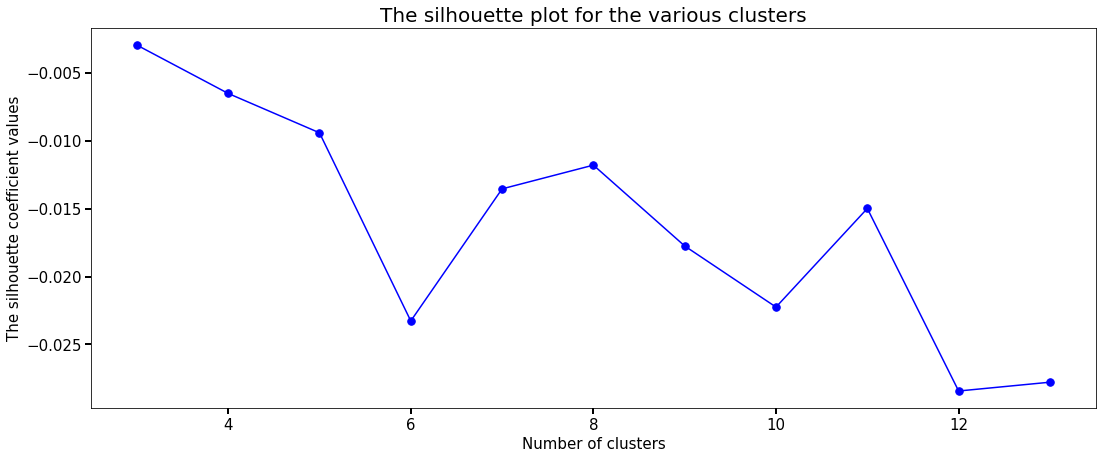

In [35]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 7)
ax.plot(k_range, result_score, marker='.', markersize=15, color='b')
ax.set_title("The silhouette plot for the various clusters", fontsize=20)
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("The silhouette coefficient values", fontsize=15)
ax.tick_params(direction='out', length=6, width=2, labelsize=15)
fig.savefig('OptimalK_silhouette_Kproto.png')

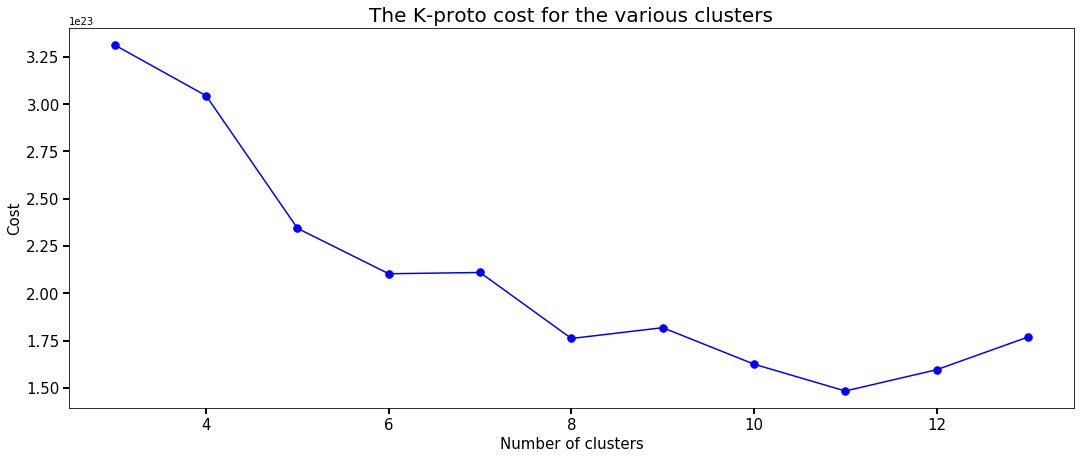

In [36]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 7)
ax.plot(k_range, result_cost, marker='.', markersize=15, color='b')
ax.set_title("The K-proto cost for the various clusters", fontsize=20)
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("Cost", fontsize=15)
ax.tick_params(direction='out', length=6, width=2, labelsize=15)

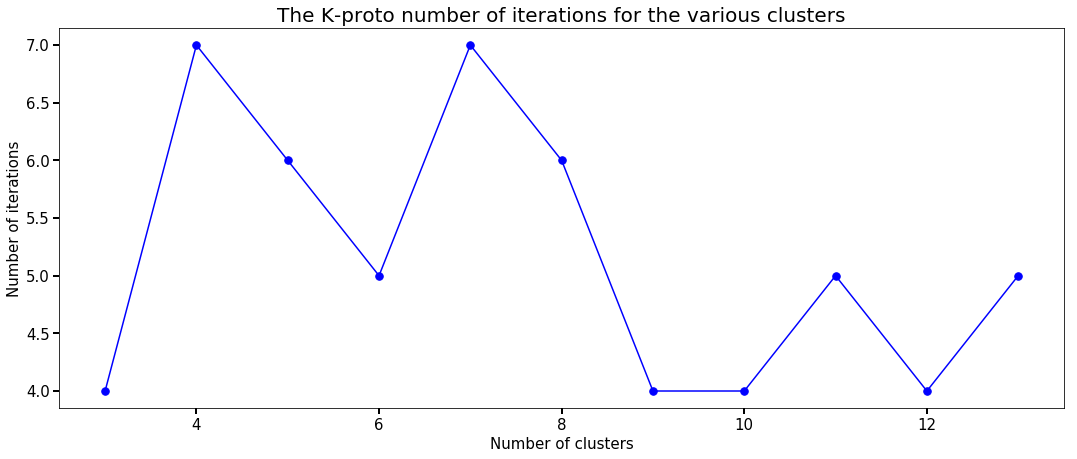

In [37]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 7)
ax.plot(k_range, result_iter, marker='.', markersize=15, color='b')
ax.set_title("The K-proto number of iterations for the various clusters", fontsize=20)
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("Number of iterations", fontsize=15)
ax.tick_params(direction='out', length=6, width=2, labelsize=15)

##### subsample 3

In [38]:
X, categorical, PolNum = process_data('PHBsample16_sss.csv', range(498, 513))
Xenc, enc_map = encode_features(X, enc_map=None)

(59159, 11) (59159, 487) (59159, 15)


In [39]:
result_cost = []
result_score = []
result_iter = []
for k in range(3,14):
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=2)
    clusters = kproto.fit_predict(X, categorical=range(498, 513))
    result_cost.append(kproto.cost_)
    result_iter.append(kproto.n_iter_)
    score = silhouette_score(Xenc, kproto.labels_, sample_size=30000)
    result_score.append(score)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 23338, ncost: 3.35683679914396e+23
Run: 1, iteration: 2/100, moves: 7183, ncost: 3.1592256413330044e+23
Run: 1, iteration: 3/100, moves: 4429, ncost: 3.0686951532276785e+23
Run: 1, iteration: 4/100, moves: 1239, ncost: 3.0504805530767934e+23
Run: 1, iteration: 5/100, moves: 617, ncost: 3.044962642708466e+23
Run: 1, iteration: 6/100, moves: 34, ncost: 3.0449372092213505e+23
Run: 1, iteration: 7/100, moves: 0, ncost: 3.0449372092213505e+23
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 16962, ncost: 2.6840215117229604e+23
Run: 1, iteration: 2/100, moves: 1691, ncost: 2.6617588512113697e+23
Run: 1, iteration: 3/100, moves: 482, ncost: 2.6581296956472344e+23
Run: 1

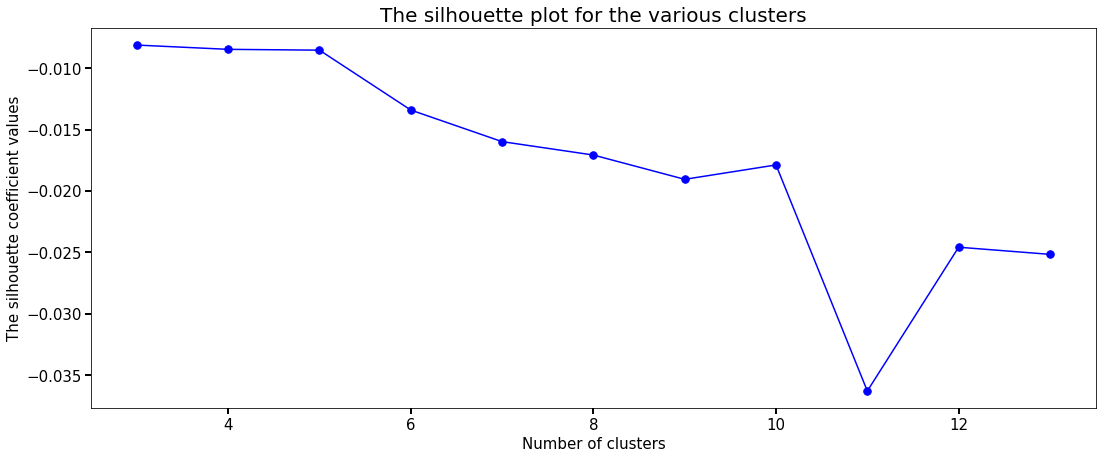

In [40]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 7)
ax.plot(k_range, result_score, marker='.', markersize=15, color='b')
ax.set_title("The silhouette plot for the various clusters", fontsize=20)
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("The silhouette coefficient values", fontsize=15)
ax.tick_params(direction='out', length=6, width=2, labelsize=15)
fig.savefig('OptimalK_silhouette_Kproto.png')

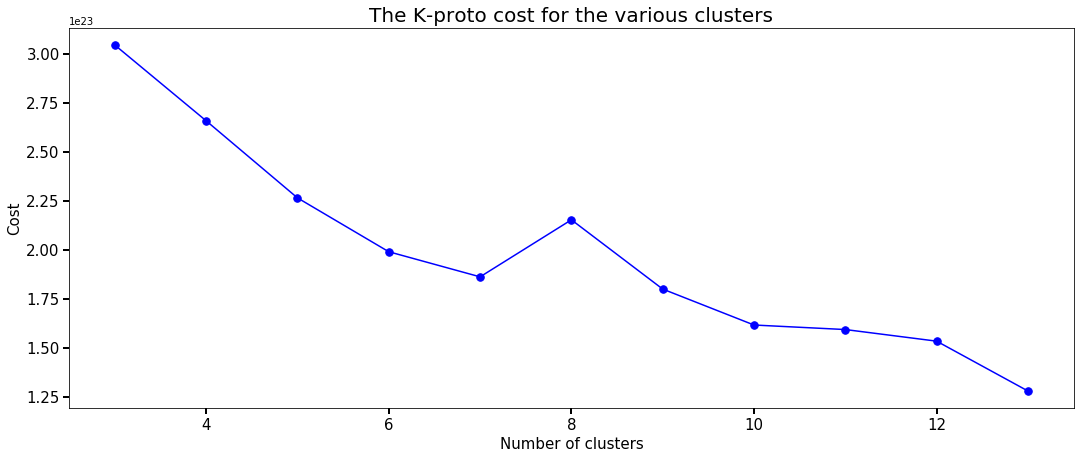

In [41]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 7)
ax.plot(k_range, result_cost, marker='.', markersize=15, color='b')
ax.set_title("The K-proto cost for the various clusters", fontsize=20)
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("Cost", fontsize=15)
ax.tick_params(direction='out', length=6, width=2, labelsize=15)

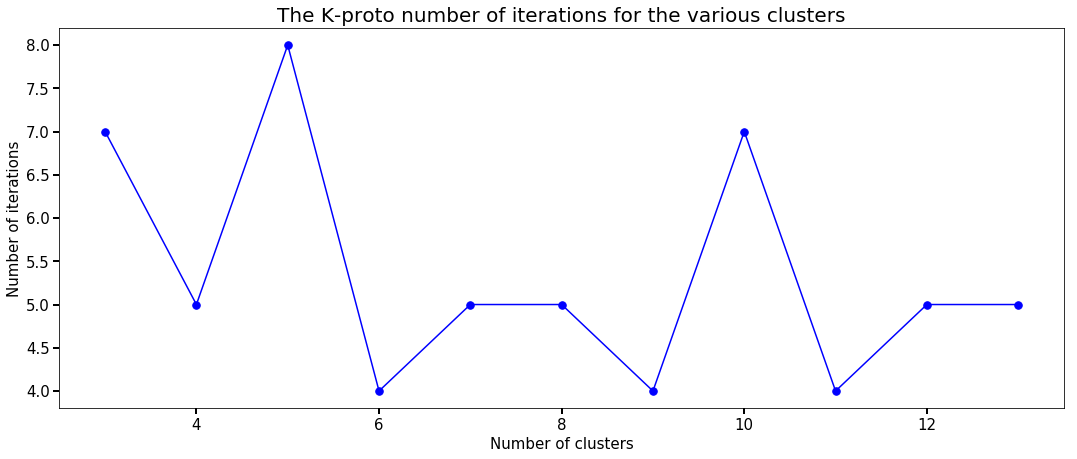

In [42]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18, 7)
ax.plot(k_range, result_iter, marker='.', markersize=15, color='b')
ax.set_title("The K-proto number of iterations for the various clusters", fontsize=20)
ax.set_xlabel("Number of clusters", fontsize=15)
ax.set_ylabel("Number of iterations", fontsize=15)
ax.tick_params(direction='out', length=6, width=2, labelsize=15)